# Classificador binário para aprovação de emprestimo

Inteligência artificial - Trabalho final

Aluno: Vinicius Casimiro da Silveira

## Configuração de ambiente e instalação de bibliotecas necessárias

In [ ]:
!source .venv/bin/activate 
!pip install opendatasets --upgrade -q
!pip install imblearn -q

In [2]:
import os
import opendatasets as od
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns 
import joblib

# Balancing 
from imblearn.over_sampling import SMOTE
from collections import Counter

from scipy.stats import zscore # outlier detections

# train data
from sklearn.model_selection import train_test_split

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.preprocessing import PolynomialFeatures, LabelEncoder, StandardScaler # encoding and normalization

## Baixando dataset do kaggle 

In [3]:
dataset = 'https://www.kaggle.com/datasets/taweilo/loan-approval-classification-data'
od.download(dataset)

Skipping, found downloaded files in "./loan-approval-classification-data" (use force=True to force download)


## Iniciando o dataframe 

In [4]:
df = pd.read_csv('loan-approval-classification-data/loan_data.csv')
df.head()




,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1


In [5]:
numerical_cols = ['person_age', 'person_income', 'loan_amnt', 'loan_int_rate', 'credit_score']
categorical_cols = ['person_gender', 'person_education', 'person_home_ownership', 'loan_intent', 'previous_loan_defaults_on_file']

In [43]:
a = pd.read_csv('loan-approval-classification-data/loan_data.csv')
a['previous_loan_defaults_on_file'].unique()
a = a.sample(5)

print(a["loan_status"])
a = a.drop("loan_status", axis=1)
a.to_csv("teste.csv", index=False)

28341    0
33009    0
26652    1
27124    0
2429     1
Name: loan_status, dtype: int64


## Fase de análise exploratória dos dados

In [7]:
df.shape

(45000, 14)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      45000 non-null  float64
 1   person_gender                   45000 non-null  object 
 2   person_education                45000 non-null  object 
 3   person_income                   45000 non-null  float64
 4   person_emp_exp                  45000 non-null  int64  
 5   person_home_ownership           45000 non-null  object 
 6   loan_amnt                       45000 non-null  float64
 7   loan_intent                     45000 non-null  object 
 8   loan_int_rate                   45000 non-null  float64
 9   loan_percent_income             45000 non-null  float64
 10  cb_person_cred_hist_length      45000 non-null  float64
 11  credit_score                    45000 non-null  int64  
 12  previous_loan_defaults_on_file  

In [9]:
print("quantity of null entries in each column")
df.isnull().sum()

quantity of null entries in each column


person_age                        0
person_gender                     0
person_education                  0
person_income                     0
person_emp_exp                    0
person_home_ownership             0
loan_amnt                         0
loan_intent                       0
loan_int_rate                     0
loan_percent_income               0
cb_person_cred_hist_length        0
credit_score                      0
previous_loan_defaults_on_file    0
loan_status                       0
dtype: int64

In [10]:
df.describe()

,person_age,person_income,person_emp_exp,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,loan_status
count,45000.000000,4.500000e+04,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000
mean,27.764178,8.031905e+04,5.410333,9583.157556,11.006606,0.139725,5.867489,632.608756,0.222222
std,6.045108,8.042250e+04,6.063532,6314.886691,2.978808,0.087212,3.879702,50.435865,0.415744
min,20.000000,8.000000e+03,0.000000,500.000000,5.420000,0.000000,2.000000,390.000000,0.000000
25%,24.000000,4.720400e+04,1.000000,5000.000000,8.590000,0.070000,3.000000,601.000000,0.000000
50%,26.000000,6.704800e+04,4.000000,8000.000000,11.010000,0.120000,4.000000,640.000000,0.000000
75%,30.000000,9.578925e+04,8.000000,12237.250000,12.990000,0.190000,8.000000,670.000000,0.000000
max,144.000000,7.200766e+06,125.000000,35000.000000,20.000000,0.660000,30.000000,850.000000,1.000000


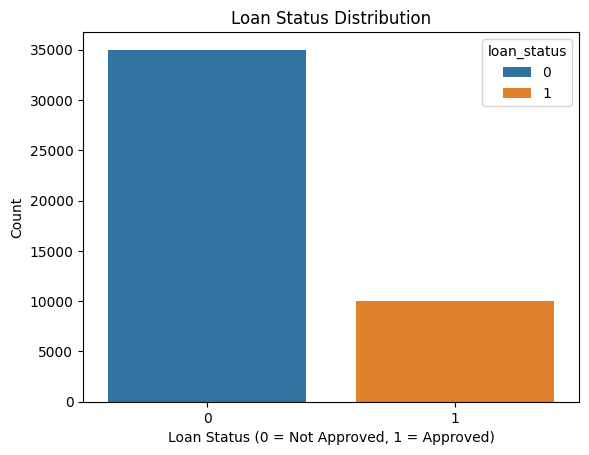

In [11]:
sns.countplot(x='loan_status', data=df, hue="loan_status")
plt.title('Loan Status Distribution')
plt.xlabel('Loan Status (0 = Not Approved, 1 = Approved)')
plt.ylabel('Count')
plt.show()

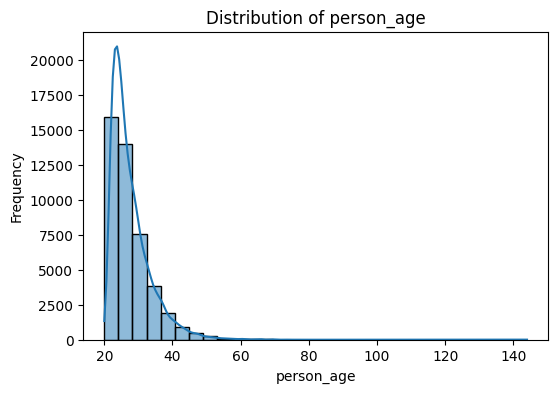

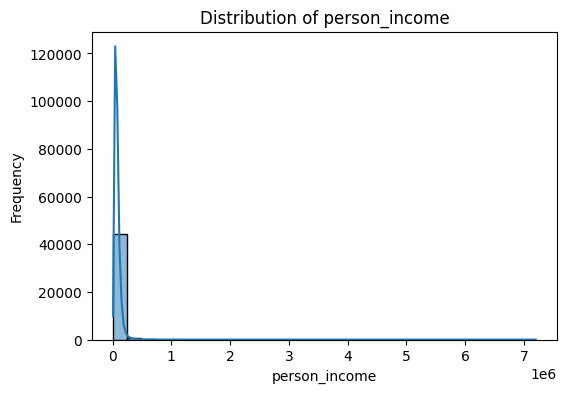

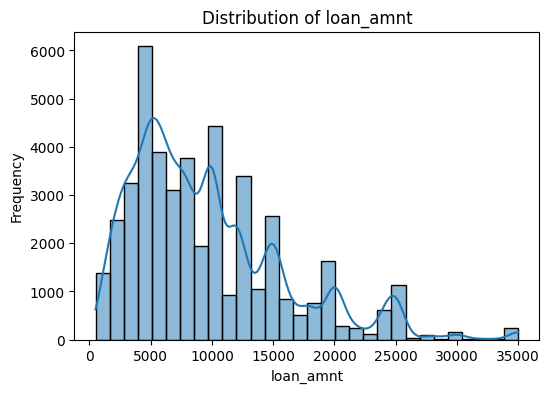

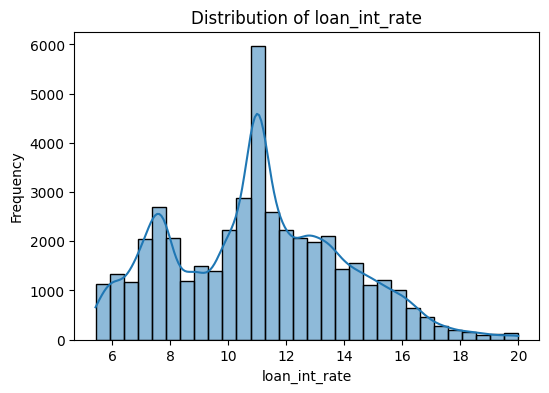

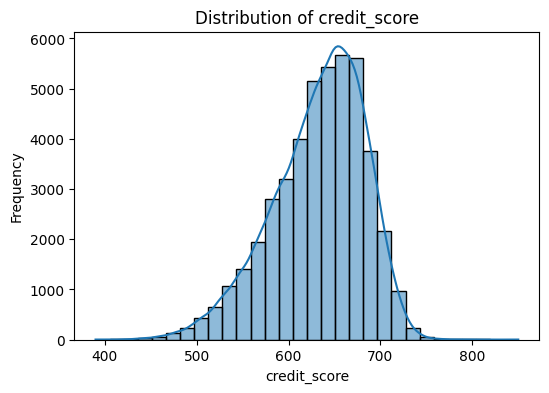

In [12]:
for col in numerical_cols:
    plt.figure(figsize=(6, 4))
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

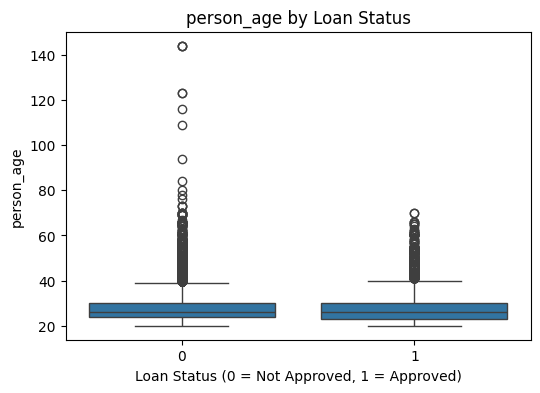

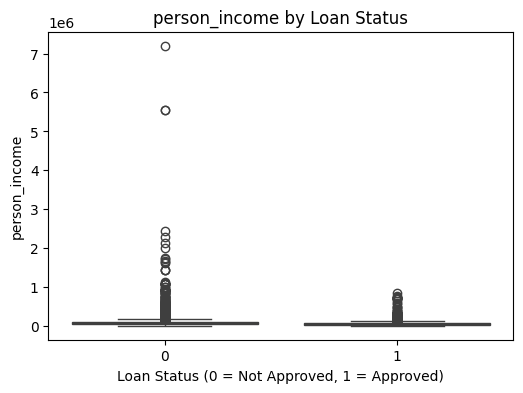

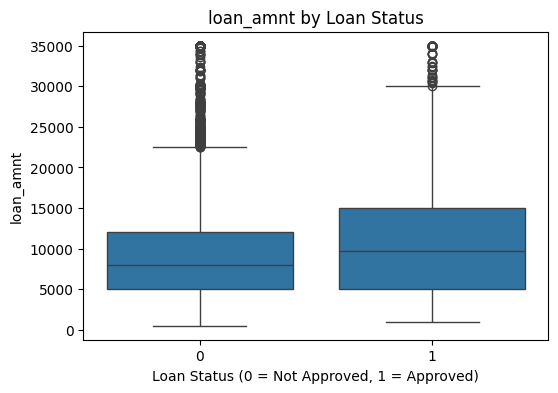

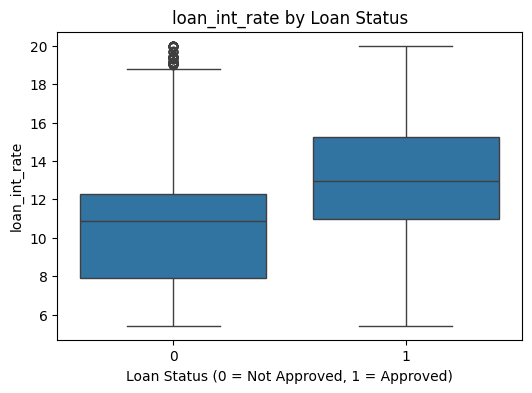

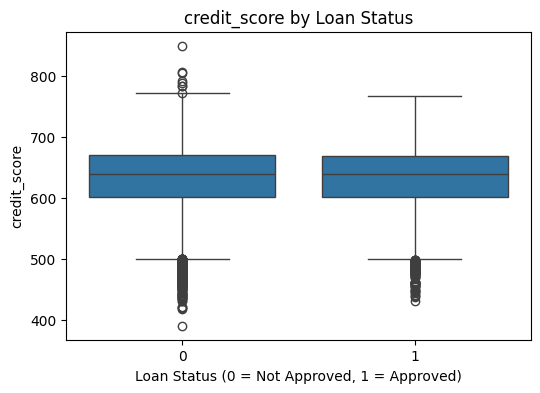

In [13]:
for col in numerical_cols:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x='loan_status', y=col, data=df)
    plt.title(f'{col} by Loan Status')
    plt.xlabel('Loan Status (0 = Not Approved, 1 = Approved)')
    plt.ylabel(col)
    plt.show()

## Normalizando e codificando dados categóricos em dados numéricos

In [14]:
le = LabelEncoder()
for col in categorical_cols:
    df[col] = le.fit_transform(df[col])

scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

df.head()

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,-0.953538,0,4,-0.104090,0,3,4.024953,4,1.683039,0.49,3.0,-1.419814,0,1
1,-1.118963,0,3,-0.846005,0,2,-1.359209,1,0.044782,0.08,2.0,-2.549975,1,0
2,-0.457264,0,3,-0.844065,3,0,-0.646600,3,0.625557,0.44,3.0,0.047412,0,1
3,-0.788113,0,1,-0.007039,0,3,4.024953,3,1.417829,0.44,2.0,0.840507,0,1
4,-0.622689,1,4,-0.176371,1,3,4.024953,3,1.095549,0.53,4.0,-0.924130,0,1


### Exportando dados

In [15]:
df.to_csv("loan-approval-classification-data/normal_loan_data.csv", index=False)

### Matriz de correlação

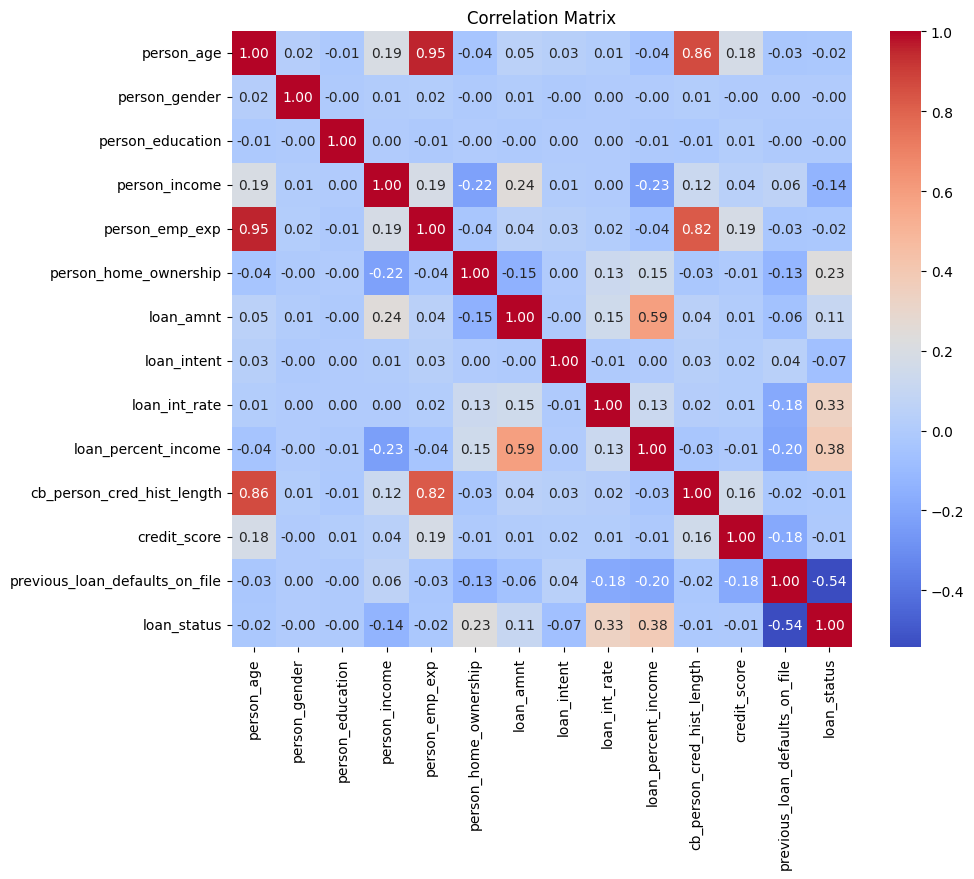

In [16]:
correlation_matrix = df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

## Tratamento de outliers

In [17]:
z_scores = df[numerical_cols].apply(zscore)

# Identify outliers with |Z-score| > 3
outliers_z = (z_scores.abs() > 3).sum()
print("Outliers detected using Z-score method:\n", outliers_z)

Outliers detected using Z-score method:
 person_age       762
person_income    286
loan_amnt        448
loan_int_rate     84
credit_score     236
dtype: int64


In [18]:
threshold = 3
outliers = (z_scores.abs() > threshold).any(axis=1)

df_no_outliers = df[~outliers]

print(f"Original dataset size: {df.shape[0]}")
print(f"Dataset size after removing outliers: {df_no_outliers.shape[0]}")

df_no_outliers.head()

Original dataset size: 45000
Dataset size after removing outliers: 43270


,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
1,-1.118963,0,3,-0.846005,0,2,-1.359209,1,0.044782,0.08,2.0,-2.549975,1,0
2,-0.457264,0,3,-0.844065,3,0,-0.646600,3,0.625557,0.44,3.0,0.047412,0,1
5,-1.118963,0,3,-0.837686,0,2,-1.121673,5,-1.298052,0.19,2.0,-1.994808,0,1
9,-1.118963,0,3,-0.840322,0,2,-1.264195,5,1.253332,0.13,3.0,0.146549,0,1
11,-1.118963,0,0,-0.835672,0,2,-0.804957,2,-0.797847,0.34,2.0,0.364650,0,1


## Checando desbalanceamento e resolvendo

In [19]:
class_distribution = df_no_outliers['loan_status'].value_counts(normalize=True) * 100

class_distribution

loan_status
0    77.975503
1    22.024497
Name: proportion, dtype: float64

### Aplicando SMOTE

In [41]:
X = df_no_outliers.drop('loan_status', axis=1)
y = df_no_outliers['loan_status']

smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X, y)

balanced_class_distribution = Counter(y_balanced)
balanced_class_distribution

Counter({0: 33740, 1: 33740})

### Visualização das transformações

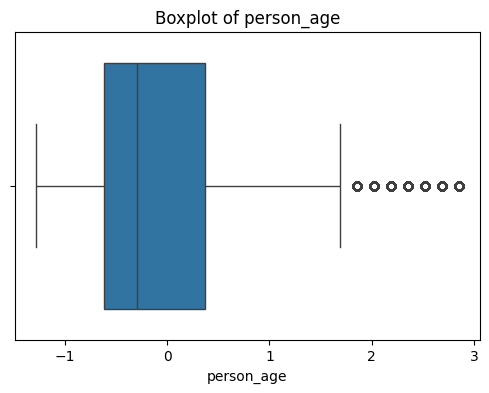

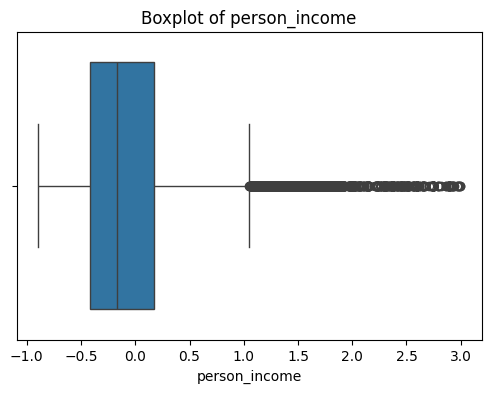

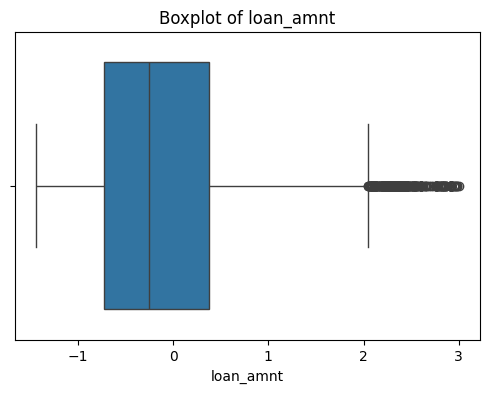

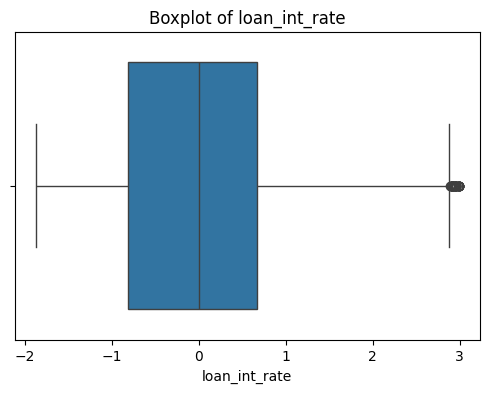

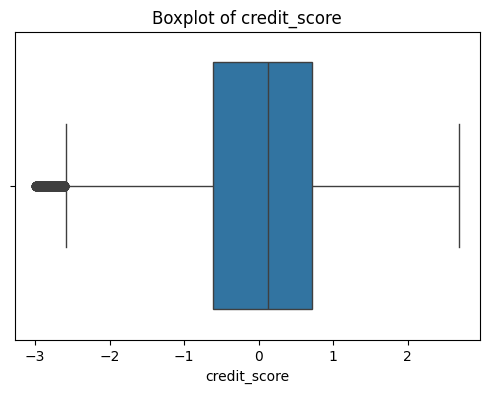

In [21]:
for col in numerical_cols:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=df_no_outliers[col])
    plt.title(f'Boxplot of {col}')
    plt.show()

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced)

print(f"Training set size: {X_train.shape[0]} rows")
print(f"Testing set size: {X_test.shape[0]} rows")

Training set size: 53984 rows
Testing set size: 13496 rows


In [23]:
logistic_model = LogisticRegression(max_iter=1000, random_state=42)
random_forest_model = RandomForestClassifier(n_estimators=100, random_state=42)

logistic_model.fit(X_train, y_train)

random_forest_model.fit(X_train, y_train)

models = {
    "Logistic Regression": logistic_model,
    "Random Forest": random_forest_model
}

results = {}
for model_name, model in models.items():
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{model_name} Accuracy: {accuracy:.4f}")
    print(classification_report(y_test, y_pred))
    results[model_name] = accuracy

best_model_name = max(results, key=results.get)
best_model_accuracy = results[best_model_name]
print(f"\nBest Model: {best_model_name} with Accuracy: {best_model_accuracy:.4f}")

Logistic Regression Accuracy: 0.8857
              precision    recall  f1-score   support

           0       0.93      0.84      0.88      6748
           1       0.85      0.93      0.89      6748

    accuracy                           0.89     13496
   macro avg       0.89      0.89      0.89     13496
weighted avg       0.89      0.89      0.89     13496

Random Forest Accuracy: 0.9381
              precision    recall  f1-score   support

           0       0.96      0.92      0.94      6748
           1       0.92      0.96      0.94      6748

    accuracy                           0.94     13496
   macro avg       0.94      0.94      0.94     13496
weighted avg       0.94      0.94      0.94     13496


Best Model: Random Forest with Accuracy: 0.9381


## Salvando modelos treinados

In [25]:
folder_path = './models'
if not os.path.exists(folder_path):
    os.mkdir(folder_path)

joblib.dump(logistic_model, 'models/RL_model.pkl')
joblib.dump(random_forest_model, 'models/RF_model.pkl')

joblib.dump(le, 'models/label_encoder.pkl')
joblib.dump(scaler, 'models/scaler.pkl')


['models/scaler.pkl']

In [39]:
rl = joblib.load("models/RL_model.pkl")
original_prediction = logistic_model.predict(X_test)
print(original_prediction)
saved_model_prediction = rl.predict(X_test)
print(saved_model_prediction)
assert (original_prediction == saved_model_prediction).all(), "Mismatch in predictions!"

[1 1 0 ... 0 0 0]
[1 1 0 ... 0 0 0]


## Observações

|  Resultados sem balanceamento | Resultados com balanceamento  |
|---|-------|
| ![wout_balancing.jpg](attachment:db9a0501-2ec0-4760-a214-3eaed4778331.jpg "Resultados sem balanceamento")  | ![with_balancing.jpg](attachment:469b1522-2140-4363-bbfb-76972133e753.jpg "Resultados com balanceamento")
 |

  